In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
import numpy as np
from sklearn.pipeline import Pipeline
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.classification.compose import (
    ColumnEnsembleClassifier,
    TimeSeriesForestClassifier,
)
from sklearn.model_selection import train_test_split
import pandas as pd
from joblib import Parallel, delayed

In [30]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'
ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1
file_label = 'co_Day1DangerAboveTreeline_small'
label = 'Day1DangerAboveTreeline'

In [31]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [32]:
i = 0
y_train_df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet')  

y_test_df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet')  
y_df = pd.concat([y_train_df, y_test_df]).reset_index(drop=True)

In [33]:
X.shape

(6000, 978, 180)

In [34]:
y_df.head()

,sample,latitude,longitude,UnifiedRegion,UnifiedRegionleft,Unnamed: 0,BottomLineSummary,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,...,WindSlab_OctagonNearTreelineSouth,WindSlab_OctagonNearTreelineSouthEast,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,parsed_date,season
0,2015-11-14 00:00:00: Grand Mesa Zone,39.00,-107.50,Grand Mesa Zone,Grand Mesa Zone,16686,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-14,15-16
1,2015-11-14 00:00:00: Grand Mesa Zone,39.25,-108.25,Grand Mesa Zone,Grand Mesa Zone,16686,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-14,15-16
2,2015-11-14 00:00:00: Gunnison Zone,38.75,-107.50,Gunnison Zone,Gunnison Zone,16688,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-14,15-16
3,2015-11-15 00:00:00: Grand Mesa Zone,39.25,-108.00,Grand Mesa Zone,Grand Mesa Zone,16698,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-15,15-16
4,2015-11-15 00:00:00: Grand Mesa Zone,39.25,-107.75,Grand Mesa Zone,Grand Mesa Zone,16698,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-15,15-16


In [5]:
y_df = y_df[y_df[label].isin(['Low', 'Moderate', 'Considerable', 'High'])]


In [6]:
#convert the labels to encoded values
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=["Low", "Moderate", "Considerable", 'High'], ordered=True)
y_df[label + '_Cat'] = y_df[label].astype(cat_type)


In [7]:
y_train_df = y_df[y_df['parsed_date'] < np.datetime64('2018-11-01')]
y_test_df = y_df[y_df['parsed_date'] >= np.datetime64('2018-11-01')]

In [8]:
y_train = y_train_df[label + '_Cat'].cat.codes.values
y_test = y_test_df[label + '_Cat'].cat.codes.values
dict( enumerate(y_train_df[label + '_Cat'].cat.categories ) )

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [9]:
y_train

array([1, 2, 2, ..., 0, 0, 1], dtype=int8)

In [10]:
y_train_df.head()

,sample,latitude,longitude,UnifiedRegion,UnifiedRegionleft,Unnamed: 0,BottomLineSummary,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,...,WindSlab_OctagonNearTreelineSouthEast,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,parsed_date,season,Day1DangerAboveTreeline_Cat
2,2015-11-14 00:00:00: Gunnison Zone,38.75,-107.50,Gunnison Zone,Gunnison Zone,16688,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-14,15-16,Moderate
5,2015-11-17 00:00:00: Front Range Zone,40.00,-105.50,Front Range Zone,Front Range Zone,16713,no-data,no-data,no-data,no-data,...,1,1,0,no-data,no-data,no-data,no-data,2015-11-17,15-16,Considerable
6,2015-11-17 00:00:00: Front Range Zone,40.50,-106.00,Front Range Zone,Front Range Zone,16713,no-data,no-data,no-data,no-data,...,1,1,0,no-data,no-data,no-data,no-data,2015-11-17,15-16,Considerable
7,2015-11-17 00:00:00: North San Juan Mountains,37.75,-107.75,North San Juan Mountains,North San Juan Mountains,16710,no-data,no-data,no-data,no-data,...,1,1,0,no-data,no-data,no-data,no-data,2015-11-17,15-16,High
8,2015-11-17 00:00:00: North San Juan Mountains,37.75,-106.50,North San Juan Mountains,North San Juan Mountains,16710,no-data,no-data,no-data,no-data,...,1,1,0,no-data,no-data,no-data,no-data,2015-11-17,15-16,High


In [108]:
def calculate_feature_mean(feature):
    print('On feature: ' + str(feature))
    return np.nanmean(X[0:5000,feature,:])

feature_means = Parallel(n_jobs=4)(map(delayed(calculate_feature_mean), range(0,num_features)))

In [109]:
X2 = np.zeros_like(X)

In [110]:
for i in range(X.shape[1]):
    X2[:,i,:] = np.nan_to_num(X[:,i,:], nan=feature_means[i])

In [111]:
X2 = X2[:, :, -30:]

In [11]:
file_no_nan = ml_path + '/X_all_' + file_label + '_no_nan.npy'

In [113]:
np.save(file_no_nan , X2)

In [114]:
del X2

In [12]:
X = np.load(file_no_nan, mmap_mode='r')

In [13]:
y_train_df.shape

(3988, 303)

In [14]:
y_train.shape

(3988,)

In [15]:
??clf.fit

Object `clf.fit` not found.


In [78]:
%%time
steps = [
    ('concatenate', ColumnConcatenator()),
    ('classify', TimeSeriesForestClassifier(n_jobs=12, n_estimators=25 ))]
clf = Pipeline(steps)
clf.fit(X[y_train_df.index,:,-30:], y_train)

CPU times: user 1min 20s, sys: 1min 52s, total: 3min 12s
Wall time: 7min 34s


Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify',
                 TimeSeriesForestClassifier(n_estimators=25, n_jobs=12))])

In [79]:
#n_estimators Default/100/200: .33
#25: .315
clf.score(X[y_test_df.index,:,-30:], y_test)

0.315

In [17]:
??ColumnEnsembleClassifier

In [23]:
X[y_train_df.index,:,-30:].astype(np.float64)

array([[[ 8.64659232e-05,  8.64659232e-05,  8.64659232e-05, ...,
          6.32857118e-05,  7.81428535e-05,  6.88571454e-05],
        [ 1.24147817e-04,  1.24147817e-04,  1.24147817e-04, ...,
          8.90000010e-05,  9.50000031e-05,  1.01999998e-04],
        [ 4.96153298e-05,  4.96153298e-05,  4.96153298e-05, ...,
          3.79999983e-05,  6.60000005e-05,  4.30000000e-05],
        ...,
        [ 9.57178846e-02,  9.57178846e-02,  9.57178846e-02, ...,
          1.19599998e-01,  1.19599998e-01,  1.19599998e-01],
        [ 9.57178846e-02,  9.57178846e-02,  9.57178846e-02, ...,
          1.19599998e-01,  1.19599998e-01,  1.19599998e-01],
        [ 9.57178846e-02,  9.57178846e-02,  9.57178846e-02, ...,
          1.19599998e-01,  1.19599998e-01,  1.19599998e-01]],

       [[ 8.64659232e-05,  8.64659232e-05,  8.64659232e-05, ...,
          8.68571369e-05,  8.00000053e-05,  4.81428578e-05],
        [ 1.24147817e-04,  1.24147817e-04,  1.24147817e-04, ...,
          1.04999999e-04,  9.30000024e

In [24]:
%%time
from sktime.classification.dictionary_based import BOSSEnsemble


clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100, n_jobs=12), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)

clf.fit(X[y_train_df.index,:,-30:].astype(np.float64), y_train)

CPU times: user 39min 33s, sys: 480 ms, total: 39min 33s
Wall time: 39min 36s


ColumnEnsembleClassifier(estimators=[('TSF0',
                                      TimeSeriesForestClassifier(n_jobs=12),
                                      [0]),
                                     ('BOSSEnsemble3',
                                      BOSSEnsemble(max_ensemble_size=5), [3])])

In [26]:
y_pred = clf.predict(X[y_test_df.index,:,-30:].astype(np.float64))

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
                                 #display_labels=class_names,
                                 #cmap=plt.cm.Blues,
                                 #normalize=normalize)

array([[ 90,  96,   9,   5],
       [ 79, 100,  15,   6],
       [ 86,  90,  17,   7],
       [ 72, 112,   7,   9]])

In [44]:
feature_names = pd.read_csv(ml_path + 'FeatureLabels_' + file_label + '.csv')['0'].values

In [45]:
feature_names.sort()

In [46]:
feature_names

array(['ABSV_1000mb_avg', 'ABSV_1000mb_max', 'ABSV_1000mb_min',
       'ABSV_100mb_avg', 'ABSV_100mb_max', 'ABSV_100mb_min',
       'ABSV_10mb_avg', 'ABSV_10mb_max', 'ABSV_10mb_min',
       'ABSV_150mb_avg', 'ABSV_150mb_max', 'ABSV_150mb_min',
       'ABSV_200mb_avg', 'ABSV_200mb_max', 'ABSV_200mb_min',
       'ABSV_20mb_avg', 'ABSV_20mb_max', 'ABSV_20mb_min',
       'ABSV_250mb_avg', 'ABSV_250mb_max', 'ABSV_250mb_min',
       'ABSV_300mb_avg', 'ABSV_300mb_max', 'ABSV_300mb_min',
       'ABSV_30mb_avg', 'ABSV_30mb_max', 'ABSV_30mb_min',
       'ABSV_350mb_avg', 'ABSV_350mb_max', 'ABSV_350mb_min',
       'ABSV_400mb_avg', 'ABSV_400mb_max', 'ABSV_400mb_min',
       'ABSV_450mb_avg', 'ABSV_450mb_max', 'ABSV_450mb_min',
       'ABSV_500mb_avg', 'ABSV_500mb_max', 'ABSV_500mb_min',
       'ABSV_50mb_avg', 'ABSV_50mb_max', 'ABSV_50mb_min',
       'ABSV_550mb_avg', 'ABSV_550mb_max', 'ABSV_550mb_min',
       'ABSV_600mb_avg', 'ABSV_600mb_max', 'ABSV_600mb_min',
       'ABSV_650mb_avg', 'ABSV_65

/home/scottcha/miniconda3/envs/sktime/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fadb6394c40> has a label of '_slope' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


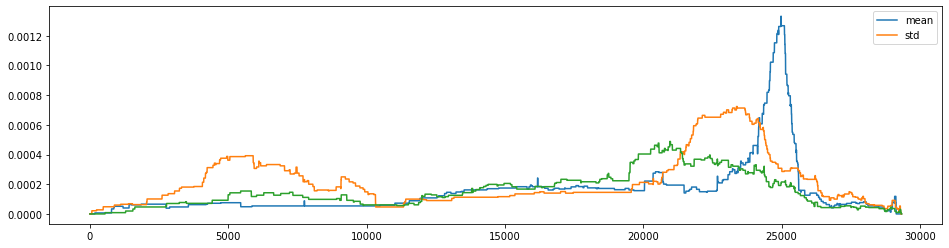

In [51]:
import matplotlib.pyplot as plt
fi2 = clf.named_steps['classify'].feature_importances_
 
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi2.plot(ax=ax);

/home/scottcha/miniconda3/envs/sktime/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fadb65008b0> has a label of '_slope' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


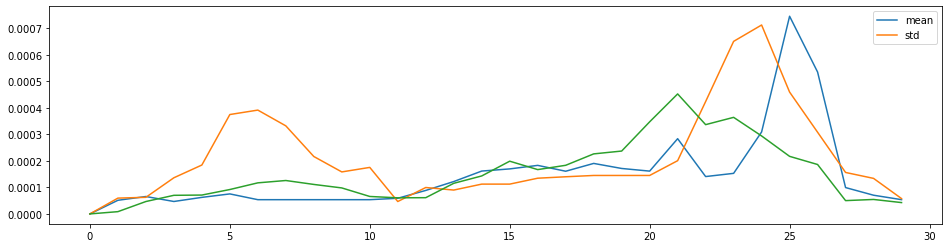

In [68]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi2[1::978].reset_index(drop=True).plot(ax=ax);

In [86]:
fi2.shape

(29340, 3)

In [84]:
features = {}
for i in range(len(feature_names)):
    features[feature_names[i]] = fi2[i::978]['mean'].sum()

In [85]:
{k: v for k, v in sorted(features.items(), key=lambda item: item[1])}

{'HGT_50mb_avg': 0.004337593446459195,
 'HGT_50mb_max': 0.004337593446459195,
 'HGT_500mb_min': 0.004349173218842644,
 'HGT_50mb_min': 0.004352308990853867,
 'HGT_550mb_avg': 0.004352308990853867,
 'HGT_550mb_max': 0.004352308990853867,
 'HGT_550mb_min': 0.004352308990853867,
 'HGT_600mb_avg': 0.004352308990853867,
 'HGT_600mb_max': 0.004352308990853867,
 'HGT_600mb_min': 0.004352308990853867,
 'HGT_650mb_avg': 0.004352308990853867,
 'HGT_30mb_max': 0.004356659587542931,
 'HGT_30mb_min': 0.004356659587542931,
 'HGT_350mb_avg': 0.004356659587542931,
 'HGT_350mb_max': 0.004356659587542931,
 'HGT_350mb_min': 0.004356659587542931,
 'HGT_400mb_avg': 0.004356659587542931,
 'HGT_400mb_max': 0.004356659587542931,
 'HGT_400mb_min': 0.004356659587542931,
 'HGT_450mb_avg': 0.004356659587542931,
 'HGT_450mb_max': 0.004356659587542931,
 'HGT_450mb_min': 0.004356659587542931,
 'HGT_500mb_avg': 0.004356659587542931,
 'HGT_500mb_max': 0.004356659587542931,
 'HGT_650mb_max': 0.004368456683905794,
 'HGT